In [10]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import scipy
import utils_dagma
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score

In [182]:
def get_block(data, n_nodes=20, index=11):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def fdr_log(data_path, true_path, seed_X, n_jobs):
    # path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_200_option_5_PLS_normX_sym1_grnboost2/'
    path = data_path
    with open(path + f'W/W_{seed_X}_1_0.pkl', 'rb') as f:
        W = pickle.load(f)
    W = W['W_est']
    Z = np.abs(W[:100, :100]) - np.abs(W[100:, :100])
    Z = Z - np.diag(np.diag(Z))
    
    # path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_200_option_10_PLS_normX_sym1_disable_norm_grnboost2'
    path = true_path
    with open(path + f'/X/X_{seed_X}.pkl', 'rb') as f:
        true_data = pickle.load(f)
    X = true_data['X']
    W_true = true_data['W_true']
    
    from joblib import Parallel, delayed
    from tqdm import tqdm
    from copy import deepcopy
    fdr=0.2
    num_feat = 100
    est_type = 'tau+'
    n_jobs = 1
    
    print(f"==============================")
    print(f"expected FDR {fdr}")
    
    Z = np.abs(W[:num_feat, :num_feat]) - np.abs(W[num_feat:, :num_feat])
    original_Z = deepcopy(Z)
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
    
    T_T_true = np.abs(W_true)
    mask = (T_T_true > 0.)
    T_T_true[mask], T_T_true[~mask] = 1, 0
    
    fdr_est_last = 1.
    t_last = np.inf
    
    def _get_t(t_list: list):
        t_last = np.inf
        fdr_est_last = None
        for t in reversed(t_list):
            if t < 0.:
                break
            if est_type == 'tau':
                fdr_est = ((Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
            else:
                fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
            
            T_T = Z.copy()
            mask = (T_T >= t)
            T_T[mask], T_T[~mask] = 1, 0
            perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
            fdr_true, power = perf['fdr'], perf['tpr']
            print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    
            if fdr_est <= fdr:
                t_last = t
                fdr_est_last = fdr_est
        return t_last, fdr_est_last
        
    interval = len(t_list) // n_jobs
    intervals = [(j * interval, (j+1) * interval) for j in range(n_jobs - 1)]
    intervals.append(
        ((n_jobs-1) * interval, len(t_list))
    )
    res1 = []
    res1 = Parallel(n_jobs=n_jobs)(
            delayed(_get_t)(
                t_list[interval[0]:interval[1]]
            ) for interval in intervals
        )
    
    
    res = np.array([list(_res) for _res in res1 if not np.isinf(_res[0]) and _res[1] is not None])
    if len(res) > 0: # otherwise, no edge being selected
        t_last = res[:, 0].min()
        t_last_idx = np.argmin(res[:, 0])
        fdr_est_last = res[t_last_idx, 1]
    
    mask = (Z >= t_last)
    Z[mask], Z[~mask] = 1, 0
    T_T = Z
    
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']
    
    if utils_dagma.is_dag(T_T):
        print("W_est is DAG")
    else:
        print("W_est is NOT DAG")
    print(f"expected fdr {fdr:.1f} | sel thresh {t_last:.4e} | "
          f"est fdr {fdr_est_last:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    print(f"==============================")

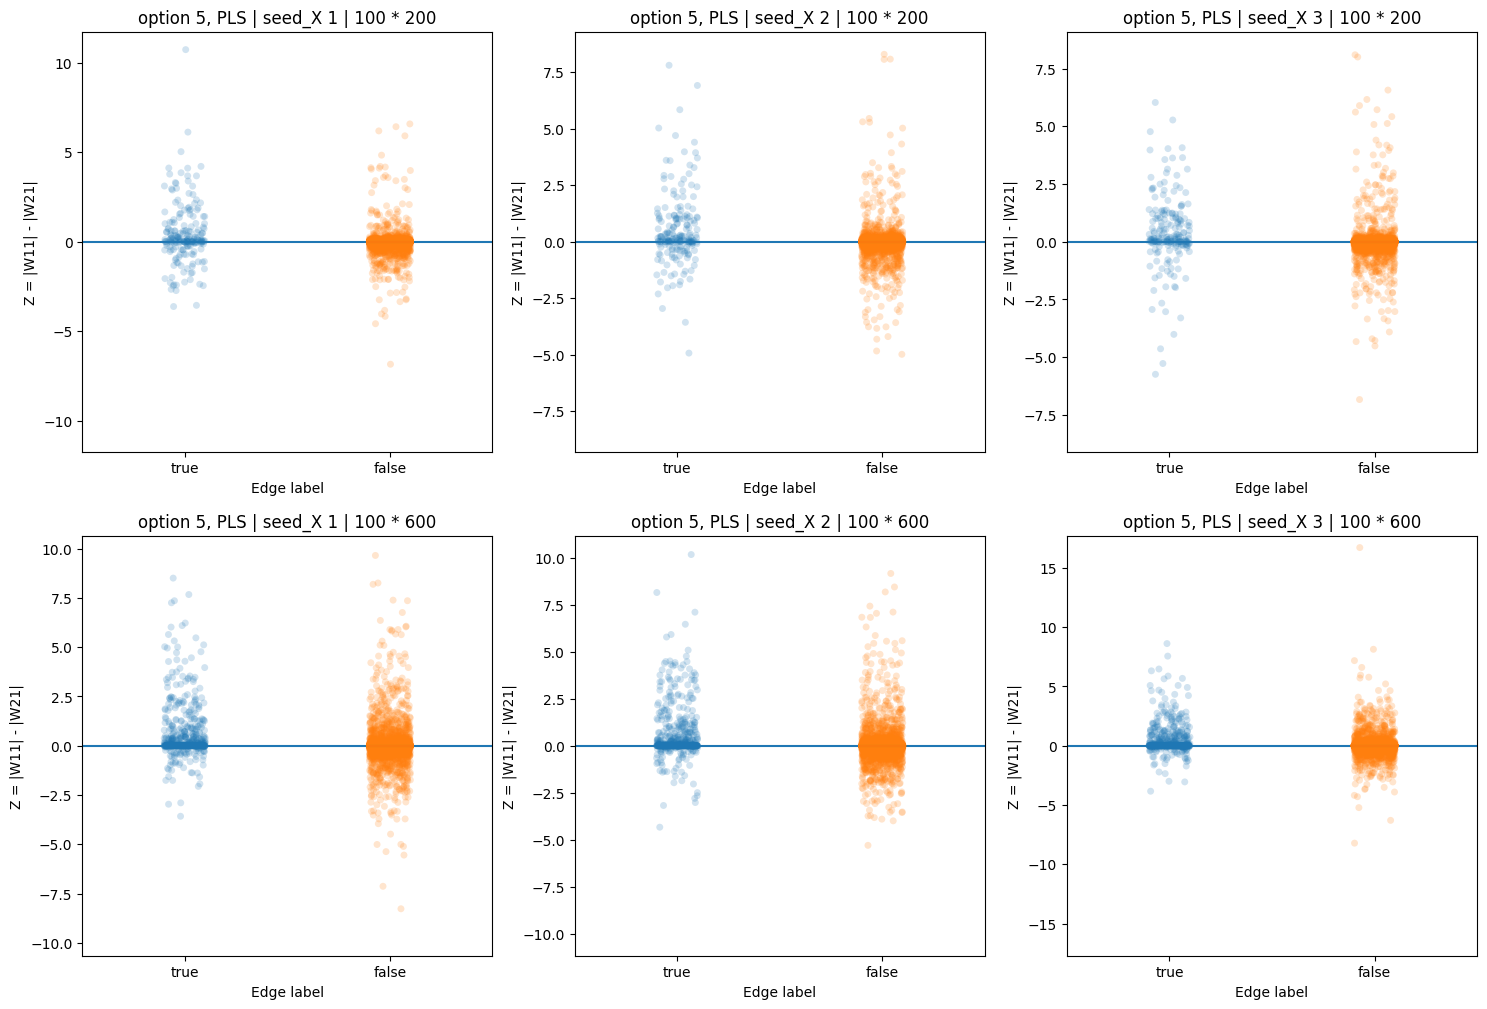

In [81]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

for i in range(3):
    ax = axs[0][i]
    path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_200_option_5_PLS_normX_sym1_grnboost2/'
    with open(path + f'W/W_{i+1}_1_0.pkl', 'rb') as f:
        W_full_genie3 = pickle.load(f)
    W_full_genie3 = W_full_genie3['W_est']
    W_full_genie3[:100, :100] = W_full_genie3[:100, :100] - np.diag(np.diag(W_full_genie3[:100, :100]))
    W_full_genie3[100:, :100] = W_full_genie3[100:, :100] - np.diag(np.diag(W_full_genie3[100:, :100]))
    Z = np.abs(W_full_genie3[:100, :100]) - np.abs(W_full_genie3[100:, :100])
    path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_200_option_5_PLS_normX_sym1_disable_norm_grnboost2'
    with open(path + f'/X/X_{i+1}.pkl', 'rb') as f:
        true_data = pickle.load(f)
    X = true_data['X']
    W_true = true_data['W_true']
    B_true = (W_true != 0)
    data = {
        'true': Z[B_true].flatten(),
        'false': Z[~B_true].flatten(),
    }
    ax = sns.stripplot(data, ax=ax, alpha=0.2)
    ax.set_title(f"option 5, PLS | seed_X {i+1} | 100 * 200")
    ax.set_xlabel("Edge label")
    ax.set_ylabel("Z = |W11| - |W21|")
    ax.set_ylim(-np.abs(Z).max()-1, np.abs(Z).max()+1)
    ax.axhline(0)

for i in range(3):
    ax = axs[1][i]
    path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_option_5_PLS_normX_sym1_grnboost2/'
    with open(path + f'W/W_{i+1}_1_0.pkl', 'rb') as f:
        W_full_genie3 = pickle.load(f)
    W_full_genie3 = W_full_genie3['W_est']
    W_full_genie3[:100, :100] = W_full_genie3[:100, :100] - np.diag(np.diag(W_full_genie3[:100, :100]))
    W_full_genie3[100:, :100] = W_full_genie3[100:, :100] - np.diag(np.diag(W_full_genie3[100:, :100]))
    Z = np.abs(W_full_genie3[:100, :100]) - np.abs(W_full_genie3[100:, :100])
    path = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_600_normX_sym1_option_10_PLS_topo_sort'
    with open(path + f'/X/X_{i+1}.pkl', 'rb') as f:
        true_data = pickle.load(f)
    X = true_data['X']
    W_true = true_data['W_true']
    B_true = (W_true != 0)
    data = {
        'true': Z[B_true].flatten(),
        'false': Z[~B_true].flatten(),
    }
    ax = sns.stripplot(data, ax=ax, alpha=0.2)
    ax.set_title(f"option 5, PLS | seed_X {i+1} | 100 * 600")
    ax.set_xlabel("Edge label")
    ax.set_ylabel("Z = |W11| - |W21|")
    ax.set_ylim(-np.abs(Z).max()-1, np.abs(Z).max()+1)
    ax.axhline(0)

In [183]:
fdr_log(
    '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_200_option_5_PLS_normX_sym1_grnboost2/',
    '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v49/v100_200_option_5_PLS_normX_sym1_grnboost2/',
    2, 4
)

expected FDR 0.2
thresh 8.2956 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 8.0827 | est fdr 0.5000 | true fdr 1.0000 | true power 0.0000
thresh 8.0711 | est fdr 0.3333 | true fdr 1.0000 | true power 0.0000
thresh 7.8105 | est fdr 0.2500 | true fdr 0.7500 | true power 0.0050
thresh 6.9167 | est fdr 0.2000 | true fdr 0.6000 | true power 0.0100
thresh 5.8432 | est fdr 0.1667 | true fdr 0.5000 | true power 0.0150
thresh 5.4568 | est fdr 0.1429 | true fdr 0.5714 | true power 0.0150
thresh 5.3083 | est fdr 0.1250 | true fdr 0.6250 | true power 0.0150
thresh 5.2889 | est fdr 0.1111 | true fdr 0.6667 | true power 0.0150
thresh 5.0325 | est fdr 0.1000 | true fdr 0.6000 | true power 0.0200
thresh 5.0286 | est fdr 0.0909 | true fdr 0.6364 | true power 0.0200
thresh 4.9840 | est fdr 0.1818 | true fdr 0.6364 | true power 0.0200
thresh 4.9301 | est fdr 0.2727 | true fdr 0.6364 | true power 0.0200
thresh 4.8371 | est fdr 0.3636 | true fdr 0.6364 | true power 0.0200
thresh 4.7261 | e